In [1]:
import os,sys, h5py, pdb,time, glob
from importlib import reload
import pylab as pl, numpy as np
from numpy import log10 as log, log as ln
from astropy import units as un, constants as cons
import scipy, scipy.stats
from matplotlib import ticker, patches
from mpl_toolkits.mplot3d import Axes3D
sys.path.append('../../pysrc')

In [2]:
import workdirs as wd
import FIRE_files as ff
from FIRE_files import cosmo, u
from projectPlotBasics import *
import first_pass as l
cmap = pl.get_cmap('viridis')
figdir = wd.basedir+'figures/'

Behroozi+18 not loaded
palettable colormaps are not installed
don't have phil's colormaps


In [3]:
CF_path = wd.basedir + '/../cooling_flow/pysrc'
sys.path.append(CF_path)
import cooling_flow as CF, HaloPotential as Halo
%matplotlib inline

/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1011: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5
/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1013: RuntimeWarning: invalid value encountered in sqrt
  return (self.profile1D('log_nHs',weight,power=2) - self.profile1D('log_nHs',weight)**2)**0.5
/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1011: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5
/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1013: RuntimeWarning: invalid value encountered in sqrt
  return (self.profile1D('log_nHs',weight,power=2) - self.profile1D('log_nHs',weight)**2)**0.5
/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1011: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5
/mnt/home/jster

/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1010: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])


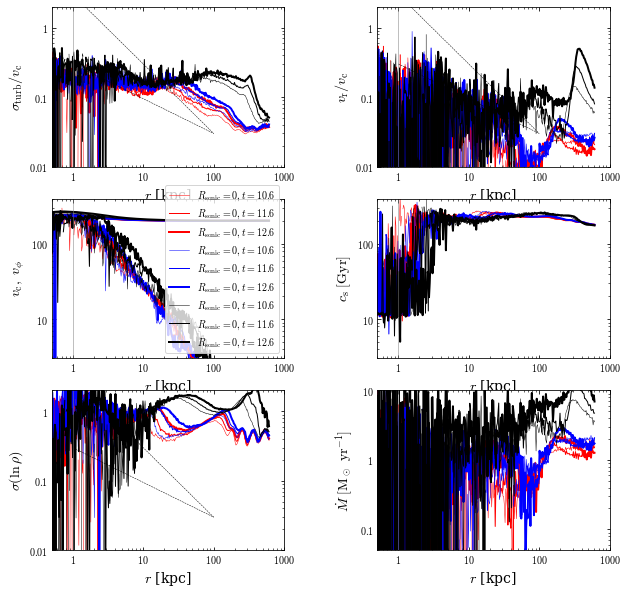

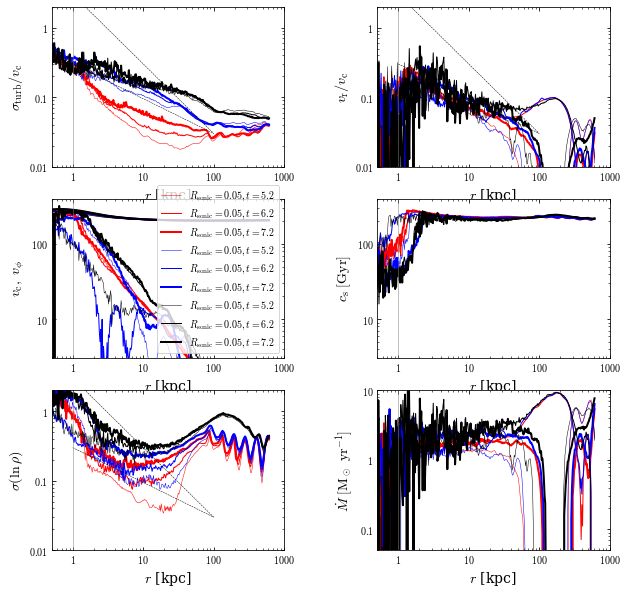

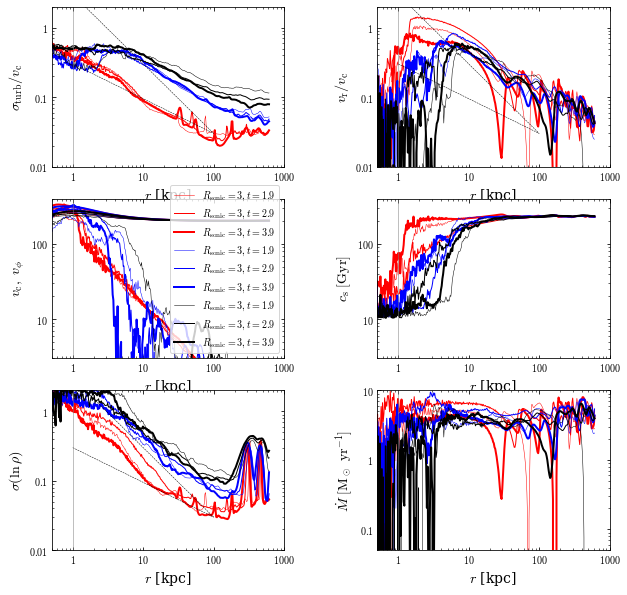

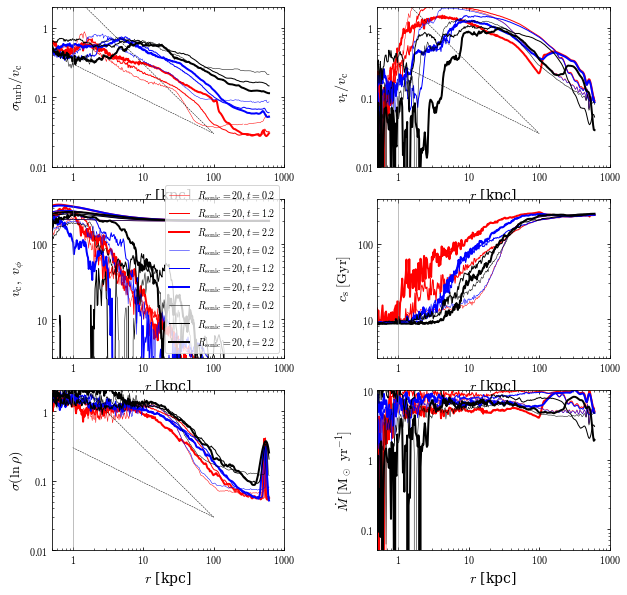

In [11]:
simname_template = 'vc200_Rs%d_Mdot%d_Rcirc%d_fgas02_res1e4_vturb%d'
vc = 200. *un.km/un.s #float(simname.split('_')[0][2:])
Rcirc = 1.*un.kpc# float(simname.split('_')[3][5:])
for isim in range(4):
    pl.figure(figsize=(10,10))
    pl.subplots_adjust(wspace=0.4)
    ax1,ax2,ax3,ax4,ax5,ax6 = [pl.subplot(3,2,i+1) for i in range(6)]
    for ivt,vturb in enumerate((3,30,100)):
        if isim==0: c,Rsonic,Mdot,snapshots = 'y',0,   226, range(212,253,20)
        if isim==1: c,Rsonic,Mdot,snapshots = 'r',0.05,1212,range(103,144,20)
        if isim==2: c,Rsonic,Mdot,snapshots = 'b',3,   3668,range(38,79,20)
        if isim==3: c,Rsonic,Mdot,snapshots = 'm',20,  4536,range(5,46,20)
        c = 'rbk'[ivt] #override color
        simname = simname_template%(Rsonic,Mdot,Rcirc.value,vturb)
        simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
        sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=50,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
        sim.z = 0 #for cooling function
        for ii,iSnapshot in enumerate(snapshots):
            lw = (0.5,1,2)[ii]
            snapshot = sim.getSnapshot(iSnapshot)
            prof = sim.getProfiler(iSnapshot)
            t = iSnapshot*0.05
            tcool2 = prof.profile1D('cs','MW',power=2)/prof.profile1D('rad_per_unit_mass', 'MW')* ((un.km/un.s)**2/(un.erg/un.s/un.g)).to('Gyr')
            Rcool = prof.rs_midbins()[np.searchsorted(tcool2,t)]
            pl.sca(ax1)
    #         pl.axvline(Rcool,c=c,lw=lw)
            pl.loglog(prof.rs_midbins(), prof.sigma_turb() / prof.vc(),c=c,lw=lw)
            pl.sca(ax2)
            pl.loglog(prof.rs_midbins(), prof.t_ff()/2**0.5/prof.t_flow(),c=c,lw=lw)
            pl.sca(ax3)
            pl.loglog(prof.rs_midbins(), prof.vc(),c=c,label=r'$R_{\rm sonic}=%s, t=%.1f$'%(ff.u.nSignificantDigits(Rsonic,1,True),t),lw=lw)
            pl.loglog(prof.rs_midbins(), prof.profile1D('v_phi','MW'),c=c,lw=lw)
            pl.sca(ax4)
            pl.loglog(prof.rs_midbins(), prof.profile1D('cs','MW') ,c=c,lw=lw)
            pl.sca(ax5)
            pl.loglog(prof.rs_midbins(), prof.sigma_log_rho('VW')*ln(10) ,c=c,lw=lw)
            pl.sca(ax6)
            pl.loglog(prof.rs_midbins(), -prof.MdotProfile() ,c=c,lw=lw)
            #pl.loglog(prof.rs_midbins(), prof.t_cool(use_actual_temperature=True,useP=False,limit_nH=False)/1000,c=c,lw=0.5)
            #pl.loglog(prof.rs_midbins(), tcool2,c=c,lw=lw)
            prof.tofile()    
    for iax,ax in enumerate((ax1,ax2,ax3,ax4,ax5,ax6)):
        pl.sca(ax)
        pl.xlim(0.5,1000)
        ax.xaxis.set_major_formatter(u.arilogformatter)
        ax.yaxis.set_major_formatter(u.arilogformatter)
        if iax<2 or iax==4:
            pl.plot([1,100],[3,  0.03],lw=0.5,ls='--',c='k')  
            pl.plot([1,100],[0.3,0.03],lw=0.5,ls='--',c='k')        
            pl.ylim(0.01,2)
        elif iax==5:
            pl.ylim(0.05,10)
        else:
            pl.ylim(3,400)
        if iax==2: pl.legend()
        pl.axvline(1.,lw=0.5,c='.5')
        pl.ylabel((r'$\sigma_{\rm turb}/v_{\rm c}$',r'$v_{\rm r}/v_{\rm c}$',
                   r'$v_{\rm c},\ v_{\phi}$',r'$c_{\rm s}\ [{\rm Gyr}]$',
                   r'$\sigma (\ln \rho)$',r'$\dot{M}\ [{\rm M}_\odot\ {\rm yr}^{-1}]$')[iax],fontsize=14)
        pl.xlabel(r'$r$ [kpc]',fontsize=14)
    pl.savefig(figdir+'turb_analysis_Mdot%d.pdf'%Mdot)

In [4]:
simnames = ['vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb10',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100',
                 'vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e3']
simname_template = 'vc200_Rs%d_Mdot%d_Rcirc%d_fgas02_res1e4_vturb%d'
vc = 200. *un.km/un.s 
Rcirc = 1.*un.kpc
for isim in range(1,4):
    for ivt,vturb in enumerate((3,30,100)):
        if isim==0: Rsonic,Mdot = 0,   226
        if isim==1: Rsonic,Mdot = 0.05,1212
        if isim==2: Rsonic,Mdot = 3,   3668
        if isim==3: Rsonic,Mdot = 20,  4536        
        simnames.append( simname_template%(Rsonic,Mdot,Rcirc.value,vturb))

# for running particle analysis on all sims

In [28]:
for isim,simname in enumerate(simnames):
    snapshot_dt_Myr = (10,50)[isim>=6]
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=snapshot_dt_Myr,pr=False,
          analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    dt = (10,50)[isim>5]; N = sim.Nsnapshots()#; print(N*dt)
    #     _ = os.system('grep TimeBetSnapshot %s../params.txt'%simdir)
    print('sbatch rusty_run.sh %s 225_%d_40 %d %d'%(simname,dt,N-101//(dt/10),N-1))

sbatch rusty_run.sh vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30 225_10_40 85 185
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30 225_10_40 329 429
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4 225_10_40 129 229
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb10 225_10_40 309 409
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100 225_10_40 362 462
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e3 225_10_40 55 155
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 225_50_40 132 151
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb30 225_50_40 124 143
sbatch rusty_run.sh vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb100 225_50_40 148 167
sbatch rusty_run.sh vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb3 225_50_40 60 79
sbatch rusty_run.sh vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb30 225_50_40 59 78
sbatch rusty_run.sh vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb100 22

In [40]:
vr2vc = []
cs2vc = []
sigturb2vc = []
sig_log_rho = []
t_ratio = []
ir = 201
for isim,simname in enumerate(simnames):
    snapshot_dt_Myr = (10,50)[isim>=6]
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=snapshot_dt_Myr,pr=False,
          analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    N = sim.Nsnapshots()
    print(simname,N,vturb)
    for ii,iSnapshot in enumerate(range(N-3,N)):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        vr2vc.append( (prof.rs_midbins()/prof.t_flow()*(un.kpc/un.Myr).to('km/s'))[ir:ir+1]/prof.vc()[ir:ir+1] )
        cs2vc.append( (prof.profile1D('cs','MW')[ir:ir+1]/prof.vc()[ir:ir+1]))
        sigturb2vc.append( prof.sigma_turb()[ir:ir+1] / prof.vc()[ir:ir+1] )
        sig_log_rho.append( prof.sigma_log_rho('VW')[ir:ir+1]*ln(10) )
        t_ratio.append (prof.profile1D('cs','MW',power=2)[ir:ir+1]/prof.profile1D('rad_per_unit_mass', 'MW')[ir:ir+1]* ((un.km/un.s)**2/(un.erg/un.s/un.g)).to('Gyr'))
        prof.tofile()

vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30 186 100.0 km / s


/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:872: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved cs2_MW
saved rad_per_unit_mass_MW


/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1011: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved cs2_MW
saved rad_per_unit_mass_MW


/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1013: RuntimeWarning: invalid value encountered in sqrt
  return (self.profile1D('log_nHs',weight,power=2) - self.profile1D('log_nHs',weight)**2)**0.5


saved cs2_MW
saved rad_per_unit_mass_MW
vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30 430 100.0 km / s
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4 230 100.0 km / s
saved cs2_MW


/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1010: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])


saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb10 410 100.0 km / s
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100 463 100.0 km / s
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e3 156 100.0 km / s
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 152 100.0 km / s
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb30 144 100.0 km / s
saved cs2_MW
saved rad_per_unit_mass_MW
saved cs2_MW
saved rad_per_unit_mass_MW
vc200_Rs0_Mdo

/tmp/ipykernel_46370/1059812598.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  marker = 'ox'[Rcirc.value==10]
/tmp/ipykernel_46370/1059812598.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  marker = 'ox'[Rcirc.value==10]
/tmp/ipykernel_46370/1059812598.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  marker = 'ox'[Rcirc.value==10]
/tmp/ipykernel_46370/1059812598.py:9: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  marker = 'ox'[Rcirc.value==10]


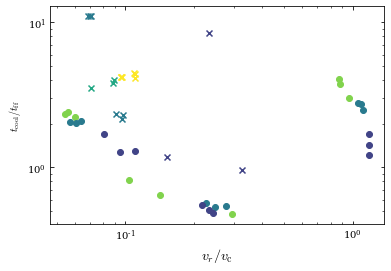

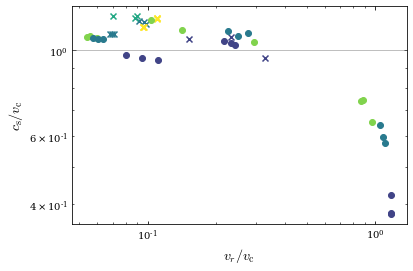

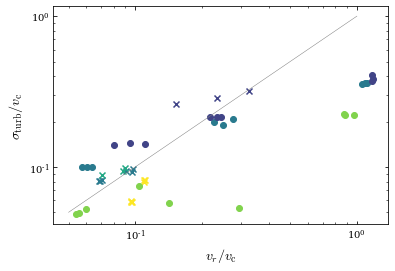

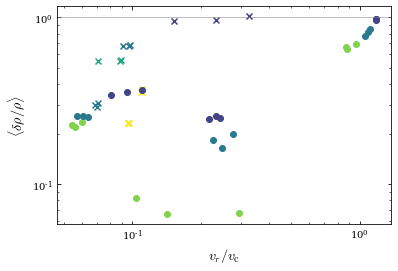

In [42]:
for iarr,arr in enumerate((t_ratio,cs2vc,sigturb2vc,sig_log_rho)):
    pl.figure()
    for isim,simname in enumerate(simnames):
        if len(simname.split('_'))==7:
            vturb = float(simname.split('_')[6][5:])*un.km/un.s
        else: vturb = 1e-3*un.km/un.s #for color
        Rcirc = float(simname.split('_')[3][5:])*un.kpc                          
        c = pl.get_cmap('viridis')(1-log(vturb.value)/2.5)
        marker = 'ox'[Rcirc.value==10]
        pl.scatter(vr2vc[isim*3:(isim+1)*3], arr[isim*3:(isim+1)*3],color=c,marker=marker)
    pl.loglog()
    pl.xlabel(r'$v_r/v_{\rm c}$',fontsize=14)    
    if iarr==0:
        pl.ylabel(r'$t_{\rm cool}/t_{\rm ff}$')        
        pl.savefig(figdir+'turb_analysis_vs_vr.pdf')                          
    if iarr==1:
        pl.ylabel(r'$c_{\rm s}/v_{\rm c}$',fontsize=14)
        pl.axhline(1,c='.5',lw=0.5)
        pl.savefig(figdir+'turb_analysis_vs_cs.pdf')                          
    if iarr==2:
        pl.ylabel(r'$\sigma_{\rm turb}/v_{\rm c}$',fontsize=14)
        pl.plot([0.05,1],[0.05,1],c='.5',lw=0.5)
        pl.savefig(figdir+'turb_analysis_vs_sigma_turb.pdf')
    if iarr==3:
        pl.ylabel(r'$\langle \delta \rho/\rho \rangle$',fontsize=14)
        pl.axhline(1,c='.5',lw=0.5)
        pl.savefig(figdir+'turb_analysis_vs_density_dispersion.pdf')
                        

/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1011: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5
/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1010: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])


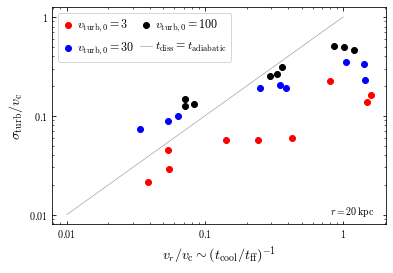

In [61]:
simname_template = 'vc200_Rs%d_Mdot%d_Rcirc%d_fgas02_res1e4_vturb%d'
vc = 200. *un.km/un.s #float(simname.split('_')[0][2:])
Rcirc = 1.*un.kpc# float(simname.split('_')[3][5:])
ax=pl.subplot(111)
for isim in range(1,4):
    for ivt,vturb in enumerate((3,30,100)):
        if isim==0: c,Rsonic,Mdot,snapshots = 'y',0,   226, range(212,253,20)
        if isim==1: c,Rsonic,Mdot,snapshots = 'r',0.05,1212,range(103,144,20)
        if isim==2: c,Rsonic,Mdot,snapshots = 'b',3,   3668,range(38,79,20)
        if isim==3: c,Rsonic,Mdot,snapshots = 'm',20,  4536,range(5,46,20)
        c = 'rbk'[ivt] #override color
        simname = simname_template%(Rsonic,Mdot,Rcirc.value,vturb)
        simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
        sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=50,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
        sim.z = 0 #for cooling function
        for ii,iSnapshot in enumerate(snapshots):
            snapshot = sim.getSnapshot(iSnapshot)
            prof = sim.getProfiler(iSnapshot)
            t = iSnapshot*0.05
            pl.scatter((prof.rs_midbins()/prof.t_flow()*(un.kpc/un.Myr).to('km/s'))[201:202]/prof.vc()[201:202],
                       prof.sigma_turb()[201:202] / prof.vc()[201:202],color=c,
                       label=(r'$v_{\rm turb,0}=%d$'%vturb,'_')[isim>1 or ii>0])
pl.text(0.8,0.01,r'$r=20\,{\rm kpc}$')
pl.ylabel(r'$\sigma_{\rm turb}/v_{\rm c}$',fontsize=14)
pl.xlabel(r'$v_r/v_{\rm c} \sim (t_{\rm cool}/t_{\rm ff})^{-1}$',fontsize=14)
pl.loglog()
pl.plot([0.01,1],[0.01,1],c='.5',lw=0.5,label=r'$t_{\rm diss}=t_{\rm adiabatic}$')
pl.legend(fontsize=12,ncol=2,handlelength=1,handletextpad=0.2,columnspacing=0.5)
ax.xaxis.set_major_formatter(u.arilogformatter)
ax.yaxis.set_major_formatter(u.arilogformatter)
pl.savefig(figdir+'turb_analysis_vs_v_r.pdf')

/mnt/home/jstern/gizmo_analysis/ipynb/subsonic_solution/../../pysrc/FIRE_files.py:1013: RuntimeWarning: invalid value encountered in sqrt
  return (self.profile1D('log_nHs',weight,power=2) - self.profile1D('log_nHs',weight)**2)**0.5


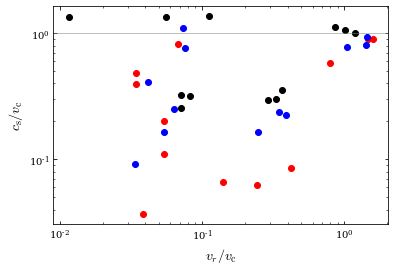

In [31]:
simname_template = 'vc200_Rs%d_Mdot%d_Rcirc%d_fgas02_res1e4_vturb%d'
vc = 200. *un.km/un.s #float(simname.split('_')[0][2:])
Rcirc = 1.*un.kpc# float(simname.split('_')[3][5:])
for isim in range(4):
    for ivt,vturb in enumerate((3,30,100)):
        if isim==0: c,Rsonic,Mdot,snapshots = 'y',0,   226, range(212,253,20)
        if isim==1: c,Rsonic,Mdot,snapshots = 'r',0.05,1212,range(103,144,20)
        if isim==2: c,Rsonic,Mdot,snapshots = 'b',3,   3668,range(38,79,20)
        if isim==3: c,Rsonic,Mdot,snapshots = 'm',20,  4536,range(5,46,20)
        c = 'rbk'[ivt] #override color
        simname = simname_template%(Rsonic,Mdot,Rcirc.value,vturb)
        simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
        sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=50,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
        sim.z = 0 #for cooling function
        for ii,iSnapshot in enumerate(snapshots):
            snapshot = sim.getSnapshot(iSnapshot)
            prof = sim.getProfiler(iSnapshot)
            t = iSnapshot*0.05
            pl.scatter((prof.rs_midbins()/prof.t_flow()*(un.kpc/un.Myr).to('km/s'))[201:202]/prof.vc()[201:202],
                       prof.sigma_log_rho('VW')[201:202]*ln(10),c=c)
pl.ylabel(r'$c_{\rm s}/v_{\rm c}$',fontsize=14)
pl.xlabel(r'$v_r/v_{\rm c}$',fontsize=14)
pl.loglog()
pl.axhline(1.,c='.5',lw=0.5)
pl.savefig(figdir+'turb_analysis_vs_c_s.pdf')

/tmp/ipykernel_46370/3948862272.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  marker = 'ox'[Rcirc.value==10]
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color

vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30 186 30.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30 430 30.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4 230 0.001 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb10 410 10.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb100 463 100.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e3 156 0.001 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb3 152 3.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb30 144 30.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb100 168 100.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb3 80 3.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb30 79 30.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs3_Mdot3668_Rcirc1_fgas02_res1e4_vturb100 147 100.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb3 53 3.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb30 46 30.0 km / s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


vc200_Rs20_Mdot4536_Rcirc1_fgas02_res1e4_vturb100 111 100.0 km / s


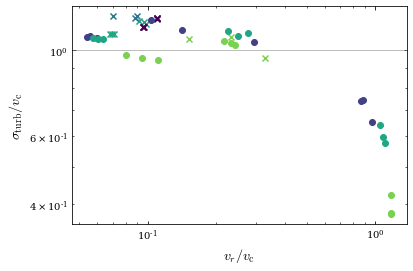

In [30]:
for isim,simname in enumerate(simnames):
    snapshot_dt_Myr = (10,50)[isim>=6]
    Rcirc = float(simname.split('_')[3][5:])*un.kpc
    Rsonic = float(simname.split('_')[1][2:])*un.kpc
    Mdot = float(simname.split('_')[2][4:])*un.Msun/un.yr/1000
    if len(simname.split('_'))==7:
        vturb = float(simname.split('_')[6][5:])*un.km/un.s
    else: vturb = 1e-3*un.km/un.s #for color
    c = pl.get_cmap('viridis')(log(vturb.value)/2.5)
    marker = 'ox'[Rcirc.value==10]
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=50,pr=False,
          analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    N = sim.Nsnapshots()
    print(simname,N,vturb)
    for ii,iSnapshot in enumerate(range(N-3,N)):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)        
        pl.scatter((prof.rs_midbins()/prof.t_flow()*(un.kpc/un.Myr).to('km/s'))[201:202]/prof.vc()[201:202], 
                   prof.sigprofile1D('cs','MW')[201:202] / prof.vc()[201:202],c=c,marker=marker)
#                    prof.profile1D('cs','MW')[201:202] / prof.vc()[201:202],c=c,marker=marker)
        prof.tofile()
pl.ylabel(r'c_{\rm s}/v_{\rm c}$',fontsize=14)
pl.xlabel(r'$v_r/v_{\rm c}$',fontsize=14)
pl.loglog()
pl.axhline(1.,c='.5',lw=0.5)
pl.savefig(figdir+'turb_analysis_vs_sigma_turb.pdf')

In [21]:
simdir

'/mnt/home/jstern/Drummond_data/vc200_Rs0_Mdot1212_Rcirc1_fgas02_res1e4_vturb0/output/'

In [17]:
prof.rs_midbins()[201]

20.702843333584827

(-20.0, 1.0)

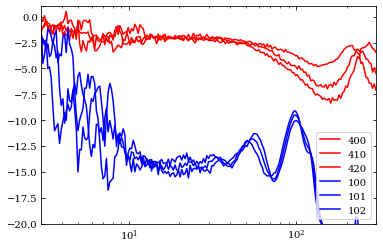

In [40]:
for isim in range(2):
    if isim==0: c,simname,snapshots = 'r','vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',range(400,430,10)
    if isim==1: c,simname,snapshots = 'b', 'vc200_Rs0_Mdot12110_Rcirc10_fgas02_res8e4_vturb30', range(100,103,1)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    # simname = 'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30'
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    for ii,iSnapshot in enumerate(snapshots):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        pl.semilogx(prof.rs_midbins(), prof.MdotProfile(),c=c,label=iSnapshot)
        prof.tofile()
pl.xlim(3,300)
pl.legend()
pl.ylim(-20,1)

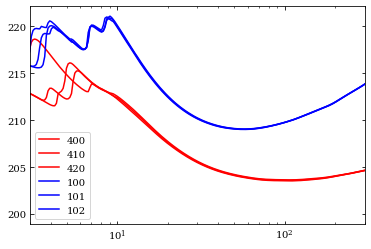

In [41]:
for isim in range(2):
    if isim==0: c,simname,snapshots = 'r','vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',range(400,430,10)
    if isim==1: c,simname,snapshots = 'b', 'vc200_Rs0_Mdot12110_Rcirc10_fgas02_res8e4_vturb30', range(100,103,1)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    # simname = 'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30'
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    for ii,iSnapshot in enumerate(snapshots):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        pl.semilogx(prof.rs_midbins(), prof.vc(),c=c,label=iSnapshot)
        prof.tofile()
pl.xlim(3,300)
pl.legend()


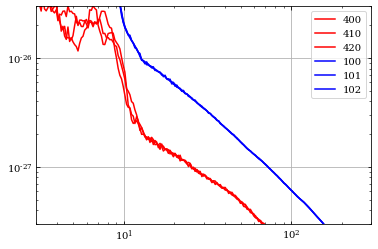

In [44]:
for isim in range(2):
    if isim==0: c,simname,snapshots = 'r','vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',range(400,430,10)
    if isim==1: c,simname,snapshots = 'b', 'vc200_Rs0_Mdot12110_Rcirc10_fgas02_res8e4_vturb30', range(100,103,1)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    # simname = 'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30'
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    for ii,iSnapshot in enumerate(snapshots):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        pl.loglog(prof.rs_midbins(), prof.rhoProfile(),c=c,label=iSnapshot)
        prof.tofile()
pl.xlim(3,300)
pl.ylim(0.3e-27,0.3e-25)
pl.legend()
pl.grid()

/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:894: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]
/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:894: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]
/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:894: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW
saved vrs_MW
saved vrs_MW


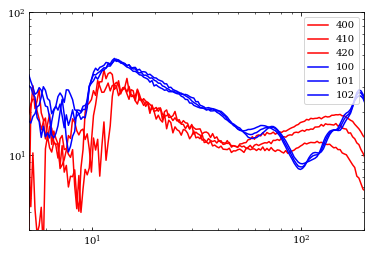

In [37]:
for isim in range(2):
    if isim==0: c,simname,snapshots = 'r','vc200_Rs0_Mdot1212_Rcirc10_fgas02_res1e4_vturb30',range(400,430,10)
    if isim==1: c,simname,snapshots = 'b', 'vc200_Rs0_Mdot12110_Rcirc10_fgas02_res8e4_vturb30', range(100,103,1)
    simdir = '/mnt/home/jstern/Drummond_data/%s/output/'%simname
    # simname = 'vc200_Rs0_Mdot121_Rcirc10_fgas02_res1e3_vturb30'
    sim = l.KY_sim(simname,simdir,200*un.kpc,origin=np.zeros(3),Rcirc = Rcirc,snapshot_dt_Myr=10,pr=False,
              analyticGravity= Halo.PowerLaw(m=0.,vc_Rvir=vc,Rvir=200*un.kpc))
    sim.z = 0 #for cooling function
    for ii,iSnapshot in enumerate(snapshots):
        snapshot = sim.getSnapshot(iSnapshot)
        prof = sim.getProfiler(iSnapshot)
        pl.loglog(prof.rs_midbins(), -prof.profile1D('vrs','MW'),c=c,label=iSnapshot)
        prof.tofile()
    pl.xlim(5,200)
    pl.ylim(3,100)
    pl.legend()

/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


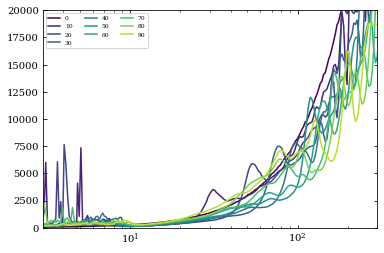

In [19]:
for ii,iSnapshot in enumerate(range(0,100,10)):
    c = pl.get_cmap('viridis')(ii/10)
    snapshot = sim.getSnapshot(iSnapshot)
    prof = sim.getProfiler(iSnapshot)
    pl.semilogx(prof.rs_midbins(), prof.t_flow(),c=c,label=iSnapshot)
pl.xlim(3,300)
pl.ylim(0,20e3)
pl.legend(fontsize=6,ncol=3)

/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:360: RuntimeWarning: divide by zero encountered in true_divide
  return j_z / (self.rs()*self.sin_theta(z_vec))


saved v_phi2_MW
saved v_phi_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1029: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])
/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:366: RuntimeWarning: invalid value encountered in multiply
  vtheta2 *= vtheta2>0 #avoid nans


saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:360: RuntimeWarning: divide by zero encountered in true_divide
  return j_z / (self.rs()*self.sin_theta(z_vec))


saved v_phi2_MW
saved v_phi_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1029: RuntimeWarning: invalid value encountered in subtract
  tmp=np.array([self.profile1D('v%s'%d,weight,power=2) - self.profile1D('v%s'%d,weight)**2 for d in ('rs','_phi','_theta')])
/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:366: RuntimeWarning: invalid value encountered in multiply
  vtheta2 *= vtheta2>0 #avoid nans


saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW
saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:891: RuntimeWarning: invalid value encountered in true_divide
  normed_hist = [hist[i,:]/hist[0,:] for i in range(1,hist.shape[0])]


saved vrs2_MW
saved vrs_MW
saved v_phi2_MW
saved v_phi_MW
saved v_theta2_MW
saved v_theta_MW


/mnt/home/jstern/gizmo_analysis/ipynb/../pysrc/FIRE_files.py:1030: RuntimeWarning: invalid value encountered in sqrt
  return (tmp.sum(axis=0)/3.)**0.5


saved massProfile0
saved massProfile2
saved massProfile4


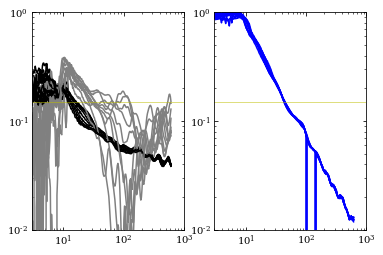